![arc-logo](admin/image/arc-logo.png)
# Projet P3
## HeadlinesDeepLearningModel
Ce notebook retrace les différentes étapes de création des modèles de deep learning avec le jeu de données des titres d'articles financiers

`Auteur` : Romain Capocasale (INF3dlm-a)

`Superviseur` : Hatem Ghorbel

`Date` : 24.01.2020

# Importation

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gensim
from gensim.utils import simple_preprocess

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU
from keras.layers.embeddings import Embedding
from keras.layers.pooling import GlobalMaxPool1D
from keras.initializers import Constant

np.random.seed(42)# to make this notebook's output stable across runs

Using TensorFlow backend.


# Chragement du jeu de données

In [2]:
dataset = pd.read_json('dataset/headlines_dataset/financialData.json')

# Suppression des phrases avec un sentiment entre -0.1 et 0.1
Les phrases avec un sentiment compris entre -0.1 et 0.1 influence en mal la précision. En effet, si le système prédit un sentiment de 0.05 pour une phrase alors que son sentiment réel et de -0.05 la prédiction sera considéré come fausse. Alors qu'en réalité l'erreur commise est toute petite (0.10).
On voit que l'on perd 283 phrase a cause de ce processus.

In [3]:
print("size before : {}".format(len(dataset)))
dataset.drop(dataset[(dataset.sentiment >= -0.1) & (dataset.sentiment <= 0.1)].index, inplace=True)
print("size after : {}".format(len(dataset)))

size before : 2866
size after : 2583


# Séparation des observations et des étiquettes
Le sentiment est une valeur continue comprise entre -1 et 1. On transforme cette intervale continue en 2 valeurs discrete 0 et 1. Le modèle sera entrainé comme un classificateur, 0 pour une phrase négative et 1 pour une phrase positive.

In [4]:
X = np.array(dataset['title'])
y = np.array([1 if s >= 0 else 0 for s in dataset['sentiment']])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Traitement du texte
Le traitement du texte est effectué avec Gensim

In [5]:
X_train_preprocessed = [' '.join(simple_preprocess(sentence)) for sentence in X_train ]
X_test_preprocessed = [' '.join(simple_preprocess(sentence)) for sentence in X_test ]

# Word embedding
Ici on attribut à chacun des mots du jeu de données un indice. Chaque mot est alors représenté dans une phrase par son indice. Comme il faut que toutes les données envoyées au modèle soient de la même taille, il faut calculer la taille de la plus longue des phrases du jeu de données. Toutes les phrases envoyées au modèle devront faire cette taille. Les mots manquants sont comblés pas l’indice 0. 

In [6]:
tokenizer_obj =  Tokenizer()

total_headlines = X_train_preprocessed + X_test_preprocessed
tokenizer_obj.fit_on_texts(total_headlines)

max_length = max([len(s.split()) for s in total_headlines])

vocab_size = len(tokenizer_obj.word_index) + 1

X_train_tokens = tokenizer_obj.texts_to_sequences(X_train_preprocessed)
X_test_tokens = tokenizer_obj.texts_to_sequences(X_test_preprocessed)

X_train_pad = pad_sequences(X_train_tokens, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_tokens, maxlen=max_length, padding='post')

# Création du réseau de neuronne
Réseau de neuronne de type LSTM inspiré du tutorial : https://towardsdatascience.com/machine-learning-word-embedding-sentiment-classification-using-keras-b83c28087456

In [7]:
EMBEDDING_DIM = 32
model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=max_length))
model.add(LSTM(16))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 22, 32)            120512    
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 123,665
Trainable params: 123,665
Non-trainable params: 0
_________________________________________________________________


# Entrainement du modèle
Le modèle est entrainé avec des echantillons de 256 données, avec 25 epochs

In [9]:
history = model.fit(X_train_pad, y_train, batch_size=64, epochs=20, verbose=2, validation_data=(X_test_pad, y_test))

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2066 samples, validate on 517 samples
Epoch 1/20
 - 1s - loss: 0.6725 - accuracy: 0.6288 - val_loss: 0.6552 - val_accuracy: 0.6344
Epoch 2/20
 - 0s - loss: 0.6548 - accuracy: 0.6288 - val_loss: 0.6477 - val_accuracy: 0.6344
Epoch 3/20
 - 1s - loss: 0.5538 - accuracy: 0.6912 - val_loss: 0.4984 - val_accuracy: 0.7969
Epoch 4/20
 - 0s - loss: 0.3096 - accuracy: 0.9177 - val_loss: 0.5050 - val_accuracy: 0.8027
Epoch 5/20
 - 0s - loss: 0.2028 - accuracy: 0.9574 - val_loss: 0.5362 - val_accuracy: 0.7930
Epoch 6/20
 - 0s - loss: 0.1469 - accuracy: 0.9676 - val_loss: 0.6015 - val_accuracy: 0.8027
Epoch 7/20
 - 0s - loss: 0.1234 - accuracy: 0.9739 - val_loss: 0.5950 - val_accuracy: 0.8066
Epoch 8/20
 - 0s - loss: 0.0969 - accuracy: 0.9811 - val_loss: 0.6346 - val_accuracy: 0.8027
Epoch 9/20
 - 0s - loss: 0.0798 - accuracy: 0.9850 - val_loss: 0.6472 - val_accuracy: 0.8104
Epoch 10/20
 - 0s - loss: 0.0707 - accuracy: 0.9869 - val_loss: 0.6635 - val_accuracy: 0.8104
Epoch 11/20
 - 0s - lo

# Evaluation du modèle
On remarque que la précison sur le jeu d'entrainement est de 99 % et de 79 % sur le jeu de test. On peut donc déduire que le modéle surévalue. On peut également remarquer que la perte augemente sur le jeu de test alors qu'elle devait diminuer.

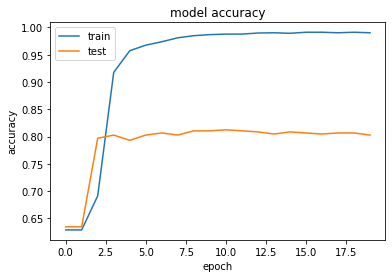

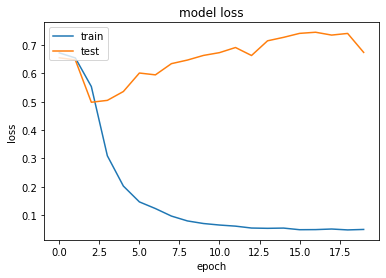

Training Accuracy: 0.9908
Testing Accuracy:  0.8027


In [10]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

loss, accuracy = model.evaluate(X_train_pad, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_pad, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

## Matrice de confusion
On peut voir que 127 phrases néagtaive on été correctement prédite, 50 phrase négative ont été incorectement prédite, 62 phrases positive ont été incorectement prédite et 278 positive ont été corectment prédite.

In [11]:
y_pred = model.predict_classes(X_test_pad)
confusion_matrix(y_pred ,y_test)

array([[139,  52],
       [ 50, 276]], dtype=int64)

# Affichage des phrases incorrectement prédite
la méthode `getModelError` retourne une liste des phrases faux postive et faux négative

In [12]:
def getModelError(y_pred, y_test, X_test):
    '''
    This method return false positive sentence and false negative sentence

    y_pred -- predicted value
    y_test -- true test value
    X_test -- test sentence
    '''
    X_test_list = X_test.tolist()
    falsePositiveSentence = []
    falseNegativeSentence = []
    for i in range(0,len(y_pred)):
        if y_test[i] == 1 and y_pred[i] == 0:
            falsePositiveSentence.append(X_test_list[i])
        elif y_test[i] == 0 and y_pred[i] == 1:
            falseNegativeSentence.append(X_test_list[i])
    return (falsePositiveSentence, falseNegativeSentence)

In [13]:
falsePositive, falseNegative = getModelError(y_pred, y_test, X_test)

# Word2vec
Le Word2vec consiste à rapprocher les mots semblables proche dans un espace de plusieurs dimension. J'ai téléchargé sur le site de glove un fichier contenant une matrice avec des valeurs précalculé pour plusieurs mots de la langues anglaises. Le code ci-dessous récupére cette matrice stocké dans le fichier `glove/glove.50d.txt` et garde seulement les mots présents dans notre jeu de données. 

In [15]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    '''Create the emedding matrix from the Glove file
    filepath -- filepath to the Glove vector file
    word_index -- tokenzizer object that contain the word index in the dataset
    embedding_dim -- dimension of the final vector
    return -- emedebbing matrix with the index and their vector
    '''
    vocab_size = len(word_index) + 1  
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath,encoding='utf8') as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [16]:
embedding_matrix = create_embedding_matrix('word2vec/glove/glove.6B.50d.txt', tokenizer_obj.word_index, EMBEDDING_DIM)

In [17]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print("Percentage of the word of the dataset present in the matrix : {} % ".format((nonzero_elements / vocab_size)*100))

Percentage of the word of the dataset present in the matrix : 94.29102496016995 % 


# Création du modèle
Utilisation d'un réseau de type CNN. 

In [18]:
model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=max_length, weights=[embedding_matrix]))
model.add(GlobalMaxPool1D())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
history = model.fit(X_train_pad, y_train,epochs=20,verbose=2,validation_data=(X_test_pad, y_test),batch_size=64)

Train on 2066 samples, validate on 517 samples
Epoch 1/20
 - 0s - loss: 0.6951 - accuracy: 0.5997 - val_loss: 0.6625 - val_accuracy: 0.6228
Epoch 2/20
 - 0s - loss: 0.6665 - accuracy: 0.6167 - val_loss: 0.6485 - val_accuracy: 0.6383
Epoch 3/20
 - 0s - loss: 0.6499 - accuracy: 0.6331 - val_loss: 0.6409 - val_accuracy: 0.6538
Epoch 4/20
 - 0s - loss: 0.6365 - accuracy: 0.6418 - val_loss: 0.6344 - val_accuracy: 0.6692
Epoch 5/20
 - 0s - loss: 0.6196 - accuracy: 0.6530 - val_loss: 0.6240 - val_accuracy: 0.6750
Epoch 6/20
 - 0s - loss: 0.5992 - accuracy: 0.6864 - val_loss: 0.6136 - val_accuracy: 0.6712
Epoch 7/20
 - 0s - loss: 0.5758 - accuracy: 0.7120 - val_loss: 0.6012 - val_accuracy: 0.6886
Epoch 8/20
 - 0s - loss: 0.5502 - accuracy: 0.7444 - val_loss: 0.5867 - val_accuracy: 0.6983
Epoch 9/20
 - 0s - loss: 0.5175 - accuracy: 0.7706 - val_loss: 0.5710 - val_accuracy: 0.6963
Epoch 10/20
 - 0s - loss: 0.4839 - accuracy: 0.7933 - val_loss: 0.5572 - val_accuracy: 0.7253
Epoch 11/20
 - 0s - lo

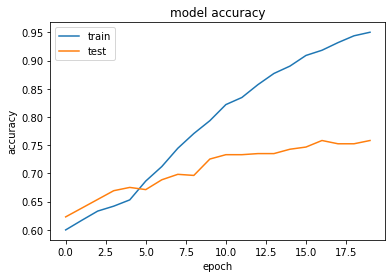

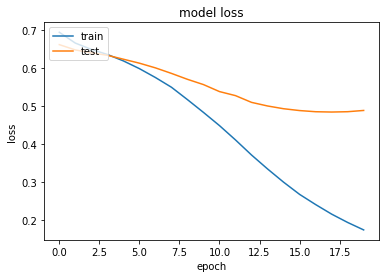

Training Accuracy: 0.9545
Testing Accuracy:  0.7582


In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

loss, accuracy = model.evaluate(X_train_pad, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_pad, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

# Conclusion
On remarque ques les modèle présenté dans le notebook surajuste beaucoup. Ces solutions sont donc à abandonnées.  Pour plus de détail merci de consulter le rapport.